# Packages Required
To run this notebook, you will need ase and quippy which can be installed by running:

$ pip install ase

$ pip install quippy

Also, make sure the GAP potential file and its sparse files are present in the same directory as this notebook.

# Code to Calculate Properties
The following code was used to compute the properties (lattice energy, elastic constants, and [100] surface energy) in Table-I of the report.

In [1]:
# Import packages
import os
import numpy as np
from ase import units
from ase.build import bulk
from ase.optimize import LBFGS
from quippy.potential import Potential
from ase.constraints import StrainFilter
from ase.lattice.cubic import BodyCenteredCubic as BCC
from scipy.linalg import solve_triangular

# Manual input values
ele = 'Fe'
crys = 'bcc'
sigma_var = 0.001 #eV/atom, regularization for variance calculation

In [2]:
# Find potential filename
fpot = [f for f in os.listdir() if f.endswith('.xml')][0]

# Load the GAP
fpot = [ f for f in os.listdir() if f.endswith('.xml')][0]
calc_a0 = Potential(param_filename=fpot)
calc_bulk = Potential(param_filename=fpot, calc_args='local_gap_variance gap_variance_regularisation='+str(sigma_var))
calc_slab = Potential(param_filename=fpot, calc_args='local_gap_variance gap_variance_regularisation='+str(sigma_var))

In [3]:
# Calculate Equilibrium Lattice Constant
# Make a cubic unit cell
atoms = bulk(ele,crys,cubic=True)
atoms.calc = calc_a0
# Apply Strain Filter
sf = StrainFilter(atoms)
# Relax the atomic positions
opt = LBFGS(sf)
opt.run(fmax=0.0001)
# Check diagonal components
a0 = np.diag(atoms.get_cell())[0]
# Print results
print(' a0 = {:.3f} A'.format(a0))

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 11:31:53    -6921.847723*       1.7363
LBFGS:    1 11:31:53    -6921.866367*       0.2786
LBFGS:    2 11:31:53    -6921.866830*       0.0119
LBFGS:    3 11:31:53    -6921.866831*       0.0001
 a0 = 2.834 A


In [4]:
# Update structure using equilibrium lattice constant a0
atoms = bulk(ele,crys,a0,cubic=True)
atoms.calc = calc_a0
# Relax the atomic positions
opt = LBFGS(atoms)
opt.run(fmax=0.0001)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 11:31:59    -6921.866831*       0.0000


True

In [5]:
# Calculate [100] surface energy
# Build bulk and slab [100]
Fe_bulk = BCC(ele,size=(8,1,1),latticeconstant=a0)
cell = Fe_bulk.get_cell() ; cell[0,:] *=2 # vacuum along x-axis for [100] surface
Fe_slab = Fe_bulk.copy() ; Fe_slab.set_cell(cell)
# Assign GAP calculators
Fe_bulk.calc = calc_bulk
Fe_slab.calc = calc_slab
# Optimize positions
opt_bulk = LBFGS(Fe_bulk)
opt_bulk.run(fmax=0.0001)
opt_slab = LBFGS(Fe_slab)
opt_slab.run(fmax=0.0001)
# Find [100] surface energy
area = np.linalg.norm(np.cross(Fe_slab.get_cell()[1,:],Fe_slab.get_cell()[2,:]))
gamma_ase = (Fe_slab.get_potential_energy() - Fe_bulk.get_potential_energy())/(2*area)
gamma_SI = (gamma_ase / units.J ) * (units.m)**2
# Find error bars (stdev)
var_bulk = np.sum(calc_bulk.extra_results['atoms']['local_gap_variance']) 
var_slab = np.sum(calc_slab.extra_results['atoms']['local_gap_variance'])
stdev = ( ( np.sqrt(var_bulk + var_slab)/(2*area) ) / units.J ) * (units.m)**2
# Print results
print('[100] surface energy = {:.3f} +/- {:.3f} J/m^2'.format(gamma_SI,stdev))    

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 11:33:51   -55374.934646*       0.0000
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 11:35:19   -55372.375999*       0.3119
LBFGS:    1 11:35:20   -55372.380088*       0.2477
LBFGS:    2 11:35:20   -55372.387241*       0.0664
LBFGS:    3 11:35:20   -55372.387521*       0.0664
LBFGS:    4 11:35:21   -55372.388792*       0.0455
LBFGS:    5 11:35:21   -55372.389044*       0.0403
LBFGS:    6 11:35:21   -55372.389223*       0.0326
LBFGS:    7 11:35:22   -55372.389353*       0.0221
LBFGS:    8 11:35:22   -55372.389474*       0.0225
LBFGS:    9 11:35:22   -55372.389531*       0.0160
LBFGS:   10 11:35:23   -55372.389565*       0.0122
LBFGS:   11 11:35:23   -55372.389593*       0.0132
LBFGS:   12 11:35:23   -55372.389616*       0.0108
LBFGS:   13 11:35:24   -55372.389628*       0.0079
LBFGS:   14 11:35:24   -55372.389637*

# Code to Check Error Bars

The following code is a brute-force alternative to quantify the uncertainty of the predicted surface energies, by sampling the posterior distribution of the GAP. 

In [6]:
# Extra packages required
from quippy.descriptors import Descriptor
from ase.io import read

In [7]:
# Open the XML file
f = open('gp4.xml')
lines = f.readlines()
f.close()

# Extract 2body kernel parameters
pos_2b = [i for i, line in enumerate(lines) if 'distance_2b' in line][0]
params = lines[pos_2b].split('=')
index = [i+1 for i, param in enumerate(params) if 'delta' in param][0]
delta_2b = float(params[index].split()[0])
index = [i+1 for i, param in enumerate(params) if 'n_sparse' in param][0]
n_2b = int(params[index].split()[0])

# Extract SOAP kernel parameters
pos_sp = [i for i, line in enumerate(lines) if 'soap' in line][0]
params = lines[pos_sp].split('=')
index = [i+1 for i, param in enumerate(params) if 'delta' in param][0]
delta_sp = float(params[index].split()[0])
index = [i+1 for i, param in enumerate(params) if 'zeta' in param][0]
zeta = int(params[index].split()[0])
index = [i+1 for i, param in enumerate(params) if 'config_type_n_sparse' in param][0]
n_sp = sum([int(line.split(':')[1]) for line in params[index].replace('}','').split() if ':' in line])

sparse_jitter=1e-12

In [8]:
# 2body data location
start = pos_2b + 2
stop = start + n_2b

# Extract 2body alphas and cutoffs
alpha_2b = np.array([ float(line.split()[2].split('"')[1]) for line in lines[start:stop] ])
cuts_spt = np.array([ float(line.split()[3].split('"')[1]) for line in lines[start:stop] ])

# SOAP data location
start = pos_sp + 2
stop = start + n_sp

# Extract SOAP alphas 
alpha_sp = np.array([ float(line.split()[2].split('"')[1]) for line in lines[start:stop] ])
# All SOAP cutoffs are 1.0

In [9]:
# Load descriptor vectors for sparse points
vecs_2b = np.loadtxt('gp4.xml.sparseX.GAP_2021_9_1_60_23_26_27_9221')
vecs_sp = np.loadtxt('gp4.xml.sparseX.GAP_2021_9_1_60_23_26_27_9222')

# Reshape SOAP vectors
len_q = int(len(vecs_sp)/n_sp)
vecs_sp = np.reshape(vecs_sp,(n_sp,len_q))

In [10]:
# 2body covariance matrix for sparse points
K_2b = delta_2b**2 * np.array([[ ci*cj*np.exp(-0.5 * (i-j)**2 ) for j,cj in zip(vecs_2b,cuts_spt)] for i,ci in zip(vecs_2b,cuts_spt)])

# SOAP covariance matrix for sparse points
K_sp = delta_sp**2 * np.array([[ np.dot(i,j) for j in vecs_sp] for i in vecs_sp])**zeta

In [11]:
# Define descriptors
desc_2b = Descriptor("distance_2b cutoff=5.0 theta_uniform=1.0")
desc_sp = Descriptor("soap l_max=12 n_max=12 cutoff=5.0 cutoff_transition_width=1.0 atom_sigma=0.5")

# Find 2body descriptors for test samples
d_2b_bulk = desc_2b.calc(Fe_bulk)['data'] 
d_2b_slab = desc_2b.calc(Fe_slab)['data']
d_2b = np.concatenate((d_2b_bulk,d_2b_slab)).flatten()
nb_bulk = len(d_2b_bulk)
nb_slab = len(d_2b_slab)

# Find cutoff for the 2body descriptors
cuts_bulk = desc_2b.calc(Fe_bulk)['covariance_cutoff'] 
cuts_slab = desc_2b.calc(Fe_slab)['covariance_cutoff'] 
cuts_new = np.concatenate((cuts_bulk,cuts_slab)).flatten()

# Find soap descriptors for test samples
d_sp_bulk = desc_sp.calc(Fe_bulk)['data'] 
d_sp_slab = desc_sp.calc(Fe_slab)['data']
d_sp = np.concatenate((d_sp_bulk,d_sp_slab))
nat = len(Fe_bulk.get_atomic_numbers())

In [12]:
# Full covariance matrix for 2body contribution
K_star_2b = delta_2b**2 * np.array([[ ci*cj*np.exp(-0.5 * (i-j)**2 ) for j,cj in zip(d_2b,cuts_new)] for i,ci in zip(d_2b,cuts_new)])
k_star_2b = delta_2b**2 * np.array([[ ci*cj*np.exp(-0.5 * (i-j)**2 ) for j,cj in zip(vecs_2b,cuts_spt)] for i,ci in zip(d_2b,cuts_new)])

# Use Cholesky decomposition to solve the linear systems
size = len(K_2b)
L = np.linalg.cholesky(K_2b + sigma_var**2 * np.eye(size))
v = solve_triangular(L, k_star_2b.T,lower=True)
V_star_2b = K_star_2b - np.dot(v.T, v)

In [13]:
# Training energy values for SOAP
Y_sp = [np.dot(vec,alpha_sp) for vec in K_sp]

# Full covariance matrix for SOAP contribution
K_star_sp = delta_sp**2 * np.array([[ np.dot(i,j) for j in d_sp] for i in d_sp])**zeta
k_star_sp = delta_sp**2 * np.array([[ np.dot(i,j) for j in vecs_sp] for i in d_sp])**zeta

# Use Cholesky decomposition to solve the linear systems
size = len(K_sp)
L = np.linalg.cholesky(K_sp + sigma_var**2 * np.eye(size))
v = solve_triangular(L, k_star_sp.T,lower=True)
V_star_sp = K_star_sp - np.dot(v.T, v)

In [14]:
# Compute predicted energies
y_2b = [np.dot(vec,alpha_2b) for vec in k_star_2b]
y_sp = [np.dot(vec,alpha_sp) for vec in k_star_sp]

In [15]:
# Sample from the posterior
N_sample = 10
samples_2b = np.array([ np.random.multivariate_normal(y_2b, V_star_2b) for i in range(N_sample) ])
samples_sp = np.array([ np.random.multivariate_normal(y_sp, V_star_sp) for i in range(N_sample) ])

In [16]:
# Compute bulk and slab energies
E_bulk_2b = np.array([ sum(sample[:nb_bulk]) for sample in samples_2b])
E_slab_2b = np.array([ sum(sample[nb_bulk:]) for sample in samples_2b])
E_bulk_sp = np.array([ sum(sample[:nat]) for sample in samples_sp])
E_slab_sp = np.array([ sum(sample[nat:]) for sample in samples_sp])
E_bulk = E_bulk_2b + E_bulk_sp
E_slab = E_slab_2b + E_slab_sp

# Calculate [100] surface energy for the samples
gamma_samples = (E_slab-E_bulk) * (units.m)**2 / (2*area*units.J)

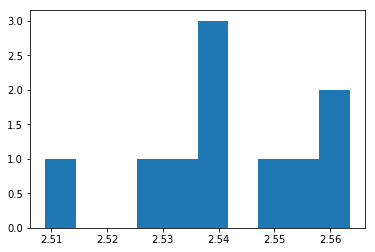

In [19]:
# Plot histogram
import matplotlib.pyplot as plt
plt.hist(gamma_samples)
plt.show()

# If sufficient samples are used, this histogram should be a roughly a Gaussian with its mean at *gamma_SI*,
# and its standard deviation should agree in order with the *stdev* value predicted by the GAP calculator.
# The exact value by this brute-force alternative method should be slightly larger, 
# as this method samples the entire posterior, while the GAP calculator uses only the 
# diagonal terms of the covariance matrix (which are the main contribution).